In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, \
MaxPooling2D, Conv2D, Lambda, Cropping2D, Convolution2D,\
AveragePooling2D
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint


from sklearn.utils import shuffle

import tensorflow as tf
#tf.python.control_flow_ops = tf

epochs = 50
batch_size = 128
image_columns = 32
image_rows = 16
image_channels = 1
side_shift = 0.3



Using TensorFlow backend.


In [2]:
size=(40*4,80*4)

def preprocessing(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

In [3]:
def load(csv, correction,folder):
    df=pd.read_csv(folder+csv, skiprows=1,\
            names=['center','left','right','steering','trottle','brake','speed'])
    
    df['center']=df.center.apply(lambda x:x.split('/')[-1])
    df['left']=df.left.apply(lambda x:x.split('/')[-1])
    df['right']=df.right.apply(lambda x:x.split('/')[-1])

    images=np.empty((len(df)*6,size[0],size[1],3), dtype=np.uint8)
    target=np.empty((len(df))*6, dtype=np.float)

    #center
    for i,fname in enumerate(df['center'].values):
        images[i]=preprocessing(cv2.imread(folder+'IMG/'+fname.strip()))

    #left
    for i,fname in enumerate(df['left'].values):
        images[i+len(df)]=preprocessing(cv2.imread(folder+'IMG/'+fname.strip()))

    #right
    for i,fname in enumerate(df['right'].values):
        images[i+2*len(df)]=preprocessing(cv2.imread(folder+'IMG/'+fname.strip()))

    target[0:len(df)]=df.steering.values
    target[len(df):2*len(df)]=df.steering.values+correction
    target[2*len(df):3*len(df)]=df.steering.values-correction

    target[3*len(df):6*len(df)]=-target[0:3*len(df)]

    for i in range(len(df)*3):
        images[i+3*len(df)]=np.fliplr(images[i])
        
    return images, target

In [4]:
%%sh

rm *.npy

In [4]:
if not os.path.exists('X.npy'):

    data=[]
    for path in ('/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/'#,
                 #'/notebooks/udacity/new_training/map2_forward/',
                 #'/notebooks/udacity/new_training/map2_backward/',
                 #'/notebooks/udacity/new_training/map2_recovery_forward/',
                 #'/notebooks/udacity/new_training/map2_recovery_backward/'
                ):
        data.append(load('driving_log.csv',0.25,path))
    
    X=np.concatenate([a[0] for a in data])
    y=np.concatenate([a[1] for a in data])
    np.save('X.npy',X)
    np.save('y.npy',y)
    del (data)
else:
    X=np.load('X.npy')
    y=np.load('y.npy')

In [5]:
print (X.shape, y.shape)

(95850, 160, 320, 3) (95850,)


In [13]:
model=Sequential()

model.add(Cropping2D(cropping=((12,4), (0,0)), \
                     input_shape=(40,80,3)))

model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(AveragePooling2D(pool_size=(4,4)))



model.add(Convolution2D(32,3, 3,
                 activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

In [14]:
model.compile(loss='mse',\
              optimizer='adam', metrics=['mean_squared_error'])

In [53]:
def preprocessing(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

generator=ImageDataGenerator(rotation_range=2, \
                             width_shift_range=0.03,\
                            height_shift_range=0.03,
                            fill_mode='nearest')

In [7]:
from sklearn.cross_validation import train_test_split

train, test= train_test_split(range(len(X)), test_size=0.15)

/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
checkpoint = ModelCheckpoint("model_tf.h5", monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                           min_delta=0.001, patience=2,
                            verbose=1, mode='min')

history = History()

tb=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)


In [9]:
gen=generator.flow(X[train],y[train],batch_size=128,shuffle=True)

In [10]:
X.shape, y.shape

((95850, 160, 320, 3), (95850,))

In [20]:
with open("model_all.json", "w") as json_file:
    json_file.write(model.to_json())

In [ ]:
model.fit_generator(gen, \
                    samples_per_epoch=len(train),\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=(X[test],y[test]),\
                    callbacks=[checkpoint, early_stop,history, tf]\
                   )

Epoch 1/100
196487/196487 [==============================] - 109s - loss: 0.0847 - mean_squared_error: 0.0847 - val_loss: 0.0703 - val_mean_squared_error: 0.0703
Epoch 2/100
196487/196487 [==============================] - 109s - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 3/100
196487/196487 [==============================] - 109s - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0641 - val_mean_squared_error: 0.0641
Epoch 4/100
196487/196487 [==============================] - 109s - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 5/100
196487/196487 [==============================] - 108s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 6/100
196487/196487 [==============================] - 108s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 7/100
196487/196487 [=

In [59]:
with open("model_nvidia.json", "w") as json_file:
    json_file.write(model.to_json())

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K



In [12]:
base_model=InceptionV3(include_top=False, input_shape=(size[0],size[1],3) )

In [13]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)


x = Dense(116, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(50, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='tanh')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='mse',\
              optimizer='adam', metrics=['mean_squared_error'])

In [14]:
with open("model_tf.json", "w") as json_file:
    json_file.write(model.to_json())

In [ ]:
import tensorflow as tf
tf.python.control_flow_ops = tf

model.fit_generator(gen, \
                    samples_per_epoch=len(train)/10,\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=(X[test],y[test]),\
                    callbacks=[checkpoint, early_stop,history]\
                   )

Epoch 1/100
8064/8147 [============================>.] - ETA: 0s - loss: 0.0927 - mean_squared_error: 0.0927  

/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_mean_squared_error improved from inf to 0.07862, saving model to model_tf.h5
8192/8147 [==============================] - 154s - loss: 0.0926 - mean_squared_error: 0.0926 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 2/100
8192/8147 [==============================] - 90s - loss: 0.0794 - mean_squared_error: 0.0794 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 3/100
8192/8147 [==============================] - 89s - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 4/100
8192/8147 [==============================] - 85s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 5/100
8192/8147 [==============================] - 91s - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0728 - val_mean_squared_error: 0.0728
Epoch 6/100
8192/8147 [==============================] - 88s - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0722 - val_me

In [29]:
import tensorflow as tf
tf.python.control_flow_ops = tf

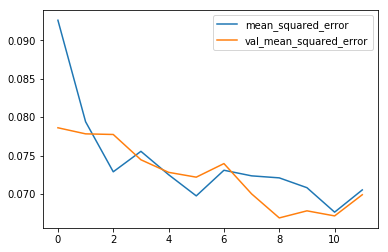

0.066888193485 8


In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')

plt.legend()
plt.show()

print (min(history.history['val_mean_squared_error']), np.argmin(history.history['val_mean_squared_error']))

In [19]:
history.history

{'loss': [0.09260721446480602,
  0.079403439071029425,
  0.072888279624748975,
  0.075551021378487349,
  0.07251321425428614,
  0.069755333475768566,
  0.073090171499643475,
  0.072361166530754417,
  0.07209851173684001,
  0.070820422713146647,
  0.067636933352332562,
  0.070532249344978482],
 'mean_squared_error': [0.092607213999144733,
  0.079403439129237086,
  0.072888279217295349,
  0.075551021785940975,
  0.072513214836362749,
  0.069755333883222193,
  0.07309017120860517,
  0.0723611667053774,
  0.072098511445801705,
  0.07082042259763377,
  0.067636933177709579,
  0.07053224858827889],
 'val_loss': [0.078616713692787416,
  0.077824946791907809,
  0.07774363234918992,
  0.074454033312810475,
  0.072818793984468666,
  0.072191015567844546,
  0.07395735911901645,
  0.070014840731129624,
  0.066888193484970423,
  0.067809660312076955,
  0.067149044551232009,
  0.069905247342886653],
 'val_mean_squared_error': [0.078616713858609202,
  0.07782494702405833,
  0.077743632017546332,
  0.

In [ ]:
from keras.applications.vgg16 import VGG16